# Plotting MLM results on the whole-brain normalized recruitment/integration

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import json
import os

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from numpy.ma import masked_array
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from functools import reduce

### Load datasets

In [3]:
# Change if needed
path_cart_raw = '../../../../Data/04-Dynamic_modular_analyses/Modular_allegiance_matrix/'
path_mlm_summary = '../../../../Data/04-Dynamic_modular_analyses/Recruitment_Integration/mlm_summary'

# Filenames
fname_cart_raw = f'allegiance_matrix_opt_mean.npy'
fname_mlm_stats = f'whole-brain_normalized_mlm_stats.csv'
fname_mlm_params = f'whole-brain_normalized_mlm_params.csv'

cart = np.load(
    os.path.join(path_cart_raw, fname_cart_raw),
    allow_pickle=True)

# Create dataframes
df_stats = pd.read_csv(os.path.join(path_mlm_summary, fname_mlm_stats), index_col=0)
df_params = pd.read_csv(os.path.join(path_mlm_summary, fname_mlm_params), index_col=0)

labels = ['AU','DM', 'FP','SEN','SAL', 'SUB', 'VIS']

n_lsn = len(labels)


In [7]:
df_params

,sys1,sys2,beta12_freqband,beta13_freqband,beta14_freqband,ttest12_freqband,ttest13_freqband,ttest14_freqband,pval12_freqband,pval13_freqband,pval14_freqband,beta12_interaction,beta13_interaction,beta14_interaction,ttest12_interaction,ttest13_interaction,ttest14_interaction,pval12_interaction,pval13_interaction,pval14_interaction
1,1,1,0.063455,0.117981,0.007401,1.644272,3.057176,0.191780,0.102286,2.661028e-03,8.481830e-01,0.187225,-0.024233,0.019835,3.419430,-0.437544,0.256152,8.223690e-04,0.665073,0.798210
2,1,2,0.029766,0.046707,0.014021,1.964857,3.083193,0.925505,0.051342,2.452186e-03,3.562413e-01,-0.005725,-0.018699,0.034517,-0.264742,-0.518456,1.128636,7.915979e-01,0.608214,0.260982
3,1,3,0.050257,0.071686,0.020554,2.129376,3.037291,0.870865,0.034912,2.831582e-03,3.852672e-01,-0.069343,-0.019431,0.015579,-2.059066,-0.391054,0.327111,4.134134e-02,0.698717,0.744073
4,1,4,0.091255,0.173537,0.105864,2.417214,4.596760,2.804183,0.016882,9.259590e-06,5.736110e-03,0.086936,-0.024762,0.074855,1.617567,-0.388267,0.984851,1.080069e-01,0.700755,0.326396
5,1,5,0.114143,0.162454,0.136017,2.744137,3.905587,3.270011,0.006834,1.436278e-04,1.343514e-03,0.079139,-0.064875,0.130340,1.347885,-0.965759,1.569724,1.798724e-01,0.342433,0.118737
6,1,6,0.162853,0.265907,0.051500,4.084401,6.669037,1.291640,0.000073,5.041484e-10,1.985371e-01,-0.204928,-0.038621,0.030061,-3.576373,-0.580141,0.370968,4.788769e-04,0.566460,0.711222
7,1,7,0.007611,-0.067257,-0.093456,0.252989,-2.235778,-3.106668,0.800635,2.689401e-02,2.276865e-03,-0.195504,-0.064175,0.112427,-4.687068,-1.223835,1.905903,6.501584e-06,0.231213,0.058713
8,2,2,-0.059437,-0.097806,0.088122,-1.913822,-3.149264,2.837466,0.057613,1.988037e-03,5.199287e-03,0.038894,0.107014,-0.060490,0.881023,1.810433,-0.968891,3.798151e-01,0.080973,0.334270
9,2,3,0.016173,0.001528,0.119153,0.614264,0.058040,4.525671,0.540003,9.537966e-01,1.244896e-05,0.018900,0.098717,-0.006334,0.512938,1.821361,-0.121546,6.088034e-01,0.079253,0.903433
10,2,4,-0.035572,-0.035403,-0.097219,-2.407538,-2.396102,-6.579814,0.017318,1.784565e-02,8.014234e-10,-0.058407,0.007021,-0.043444,-2.804079,0.179748,-1.474810,5.763349e-03,0.858645,0.142509


## Change data format
Split data into set of upper-triangular arrays of size $7 \times 7$

### Multi-level modeling (MLM) comparison arrays

Represents results of statistical model comparison. First index is coding different models (0: group model; 1: session model; 2: interaction model) while next indices are coding LSNs:

chi_mlm: $\chi^2$ test value for single model evaluation
pval_mlm: corresponding $p$ values

### Estimated model parameter arrays

Respresents estimated influence of different dependent variables on independent variable (here recruitment or integration). First index is coding different session pairs (0: Naive vs Early; 1: Naive vs Middle; 2: Naive vs Late) while next indices are coding LSN group assignment:

CHANGE THESE TO FREQUENCY BANDS

beta_ses: linear regression $\beta$ parameters for session model
beta_inter: linear regression $\beta$ parameters for interaction model

In [8]:
chi_mlm = np.zeros((3, n_lsn, n_lsn))
pval_mlm = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_stats.iterrows():
    i, j = int(row.sys1) - 1, int(row.sys2) - 1
    chi_mlm[0, i, j] = row.chi_sex
    chi_mlm[1, i, j] = row.chi_Freqband
    chi_mlm[2, i, j] = row.chi_interaction

    pval_mlm[0, i, j] = row.pval_sex
    pval_mlm[1, i, j] = row.pval_Freqband
    pval_mlm[2, i, j] = row.pval_interaction


### Note that I think the Beta parameters are comparing their 4 sessions - for me, I might want to do freq band

beta_freq = np.zeros((3, n_lsn, n_lsn))
beta_inter = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_params.iterrows():
    
    i, j = int(row.sys1) - 1, int(row.sys2) - 1
    
    for freq in range(3):
        beta_freq[freq, i, j] = row[f'beta1{freq+2}_freqband']
        beta_inter[freq, i, j] = row[f'beta1{freq+2}_interaction']
        



In [9]:
def correct_pvals_array(pvals, method='fdr_bh'):
    ''' Perform multiple comparison correction on p-values arranged into square
    array. 
    
    Args:
        pvals (array_like): 
            Upper-triangular array of p-values.
        method (str):
            Correction method passed to multipletests function from statsmodels
            library.
            
    Returns
        (array_like): Corrected p-vales. Same dimension as input array.
    '''

    upper_ind = np.triu_indices(pvals.shape[0], k=0)
    pvals_vec = pvals[upper_ind]

    pvals_vec_corrected = multipletests(
        pvals_vec,
        alpha=0.05,
        method=method,
        is_sorted=False,
        returnsorted=False,
        )[1]

    pvals_corrected = np.zeros(pvals.shape)
    pvals_corrected[upper_ind] = pvals_vec_corrected
    return pvals_corrected

def symmetrize(matrix):
    '''Symmetrizes triangular matrix'''
    from warnings import warn

    if np.allclose(matrix, matrix.T):
        warn('matrix is already symmetric')
        return matrix
    else:
        return matrix + matrix.T - np.diag(np.diag(matrix))

### Manage plt.rc settings

In [10]:
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
plt.rc('figure', figsize=(10, 10))
plt.rc('axes', linewidth=3)

# Colobar settings
cbar_width = 0.03
cbar_offset = 0.02

# Create custom colormap (diverging black - white - black)
col_gray = (.75, .75, .75)
col_white = (1, 1, 1)
newcmp = LinearSegmentedColormap.from_list(
    'gray_div', 
    [col_gray, col_white, col_gray], 
    N=128)

### Generate figures

In [11]:
def matrix_pval_plot(pvals, cvals, labels, vmin, vmax, outpath=None, **savefig_kwargs) -> None:
    '''Creates matrix plot color coded according to underying p-values. 
    
    Args:
        pvals (array-like): 
            Symmetric matrix of p-values.
        cvals (array-like):
            Corresponding values. These values will actually determine color 
            intensity in heatmap cells.
        labels (list):
            List of labels for both matrix axis. Should have length equal to 
            pvals.shape[0].
        outpath (str)[optional]:
            If specified plot will be saved under path specified in outpath.
        savefig_kwargs (dict)[optional]:
            Optional kwargs passed to fig.savefig() function.
    '''
    # Correct p-values if needed
    pvals_corrected = symmetrize(correct_pvals_array(pvals))
    cvals_sig = masked_array(symmetrize(cvals), symmetrize(pvals) > .05)

    fig, ax = plt.subplots(facecolor='w')

    # Manage labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Plot heatmaps
    clim = [-np.max(np.abs(cvals_sig)), np.max(np.abs(cvals_sig))]
    im_sig = ax.imshow(cvals_sig, cmap='RdBu_r', clim=clim, vmin = vmin, vmax = vmax)

    # Create colorbars
    cb_sig_axes = fig.add_axes(
        [ax.get_position().x1 + cbar_offset, ax.get_position().y0,
         cbar_width, ax.get_position().height])
    cb_sig = plt.colorbar(im_sig, cax=cb_sig_axes)

    # Annotate significant p-vals (FDR corrected)
    ind_corrected = np.nonzero((pvals_corrected < 0.05) * (pvals_corrected != 0))

    for i, j in zip(*ind_corrected):
        ax.text(j, i + .11, '*', ha="center", va="center", color="w", 
                fontsize=22, fontweight='bold')

    plt.plot()

    if outpath:
        fig.savefig(outpath, **savefig_kwargs)

### Figures description

- Colored tiles represent significant uncorrected effect ($p < 0.05$).
- Astrerisks represent significant corrected effect ($p_{FDR} < 0.05$).
- For MLM statistics color is coding estimated $\beta$ parameter for change between Delta and other frequency bands.
- For brain-behavior correlations color is coding correlation coefficient $\rho$.

### Figure 1.

Significant effects for group model.

### Figure 2.

Significant effects for interaction model.

In [12]:
def reorder(mat, new_order):
    return mat[:, new_order][new_order]

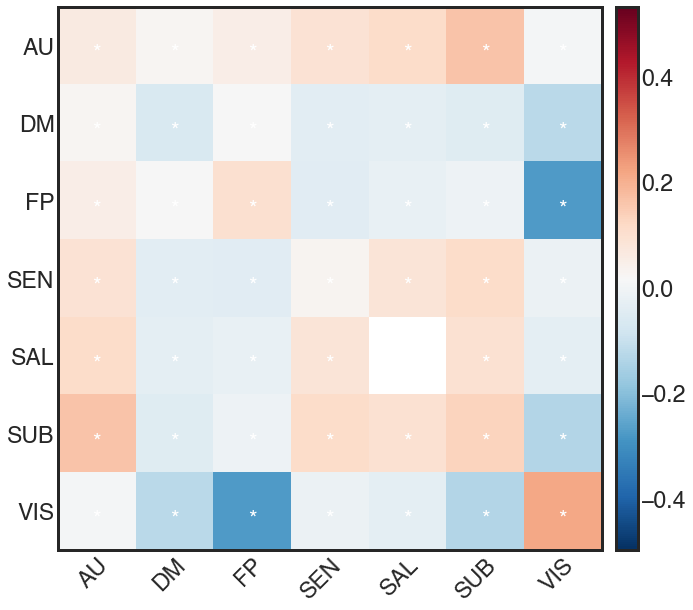

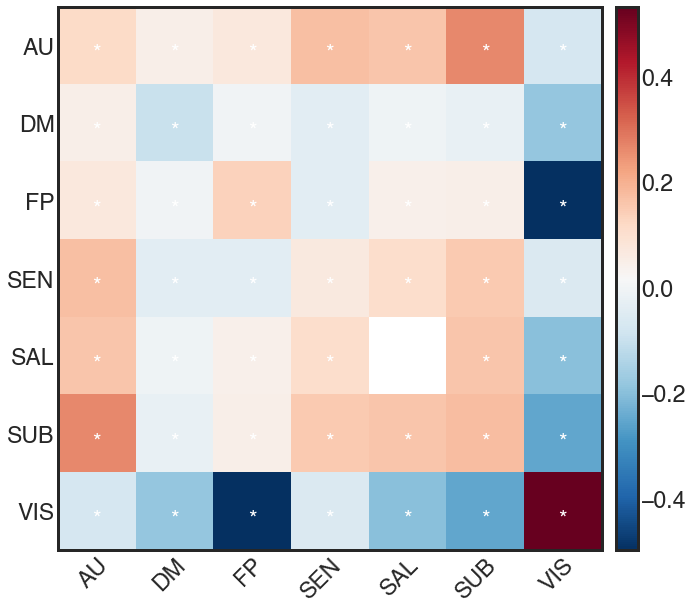

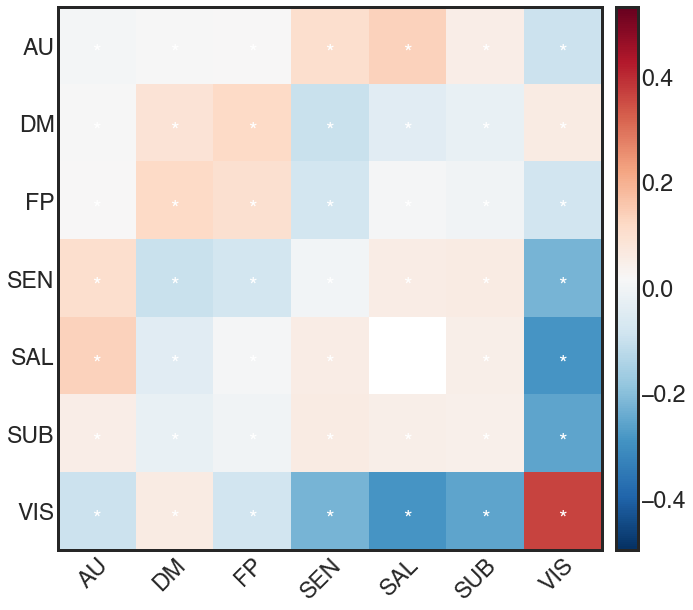

In [13]:
# Plot session heatmaps
for i in range(3):
    matrix_pval_plot(
        pval_mlm[1], 
        beta_freq[i], 
        labels, 
        vmax=beta_freq.max(),
        vmin=beta_freq.min(),
        #outpath=f'mlm_session_{dataset}_{atlas}_{i+1}.pdf', 
        bbox_inches='tight'
    )


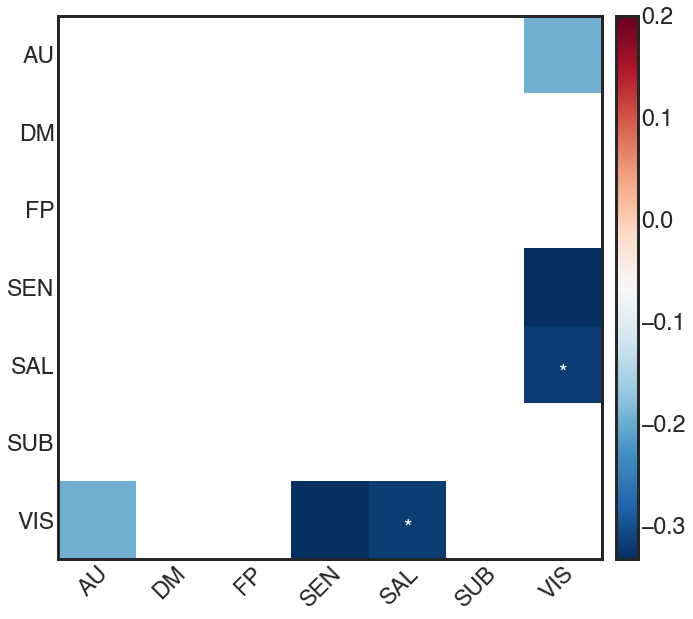

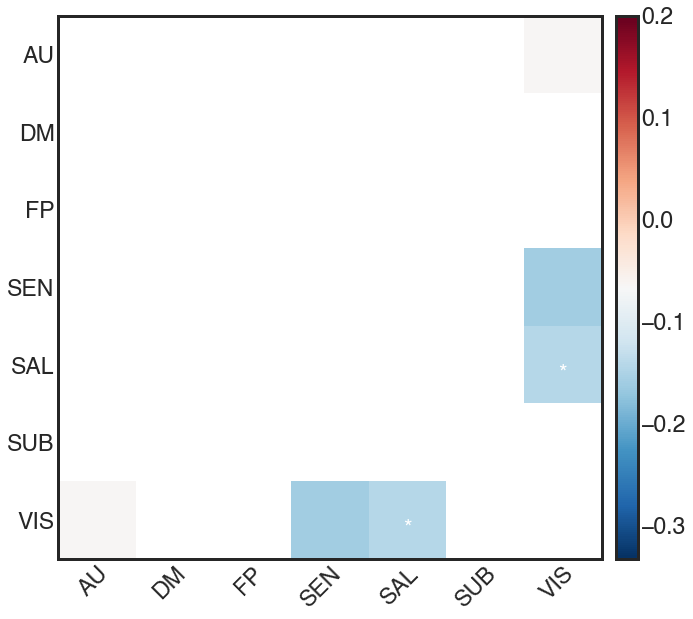

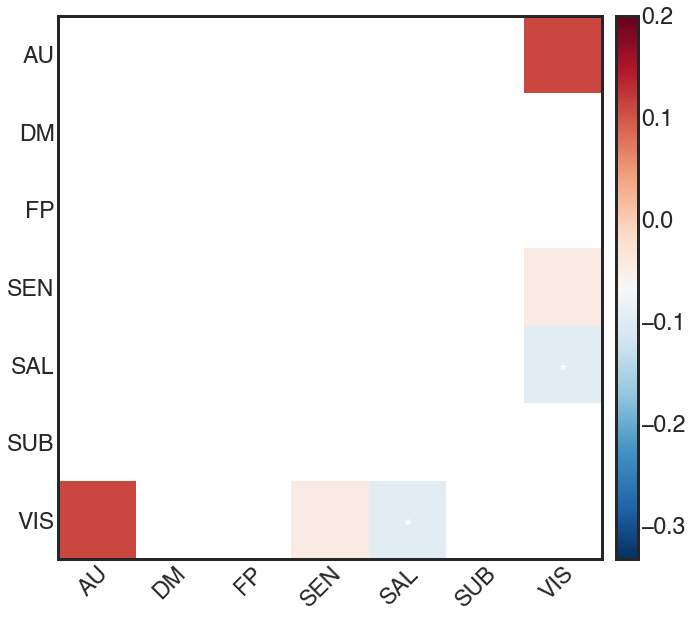

In [14]:
# Plot interaction heatmaps
for i in range(3):
    matrix_pval_plot(
        pval_mlm[2],
        beta_inter[i],
        labels, 
        vmax=0.2,#beta_inter.max(),
        vmin=beta_inter.min(),
        #outpath=f'mlm_interaction_{dataset}_{atlas}_{i+1}.pdf',
        bbox_inches='tight'
    )